In [1]:
import math

import scipy
import numpy as np
import keras.applications.mobilenet_v2 as k_mobilenet_v2
import keras.preprocessing.image as k_image
import keras.models as k_models
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Heat-map generation 

In [2]:
def generate_heatmap(model, x, shutter=(10, 10), shutter_value=[0,0,0]):
    
    # prepare output matrix
    heatmap = np.zeros(x.shape[1:3])
    
    # get main image prediction
    base_predictions = model.predict(x)[0]
    base_class = base_predictions.argmax()
    base_percentage = base_predictions[base_class]
    
    # slide shutter over image
    for row in range(math.ceil(x.shape[2] / shutter[1])):
        for col in range(math.ceil(x.shape[1] / shutter[0])):
            
            # calculate selector
            sel = (
                0,
                slice(row*shutter[1], min((row+1)*shutter[1], x.shape[2])),
                slice(col*shutter[0], min((col+1)*shutter[0], x.shape[1]))
            )
            
            # copy image and apply shutter
            img = x.copy()
            img[sel] = shutter_value
            
            # calculate prediction
            percentage = model.predict(img)[0][base_class]
            
            # add to heatmap
            heatmap[sel[1:]] = base_percentage - percentage
    
    return heatmap

In [3]:
def plot_heatmap(heatmap, blur=0.0, cmap='jet', **kwargs):
    
    # blur heatmap
    if blur:
        heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, blur)
    
    # plot heatmap
    plt.matshow(heatmap, cmap=cmap, **kwargs)
    plt.colorbar()
    plt.show()

def plot_heatmap_cover(heatmap, x, blur=0.0, cutoff=0.0, **kwargs):
    
    # normalize heatmap
    heatmap = heatmap.copy()
    heatmap -= heatmap.min()
    heatmap /= heatmap.max() or 1.0
    
    # cutof heatmap
    heatmap[heatmap < cutoff] = 0.0
    
    # blur heatmap
    if blur:
        heatmap = scipy.ndimage.filters.gaussian_filter(heatmap, blur)
    
    # cover image
    image = (x - 0.5) * heatmap[:,:,None] + 0.5
    
    plt.imshow(image, **kwargs)
    plt.show()

## Example network

In [4]:
model = k_mobilenet_v2.MobileNetV2(weights='imagenet', include_top=True)

Instructions for updating:
Colocations handled automatically by placer.


### Proboscis monkey

In [5]:
image_path = 'images/nosacz.jpg'

# open, parse and preprocess image
image = k_image.load_img(image_path, target_size=(224, 224))
x = k_image.img_to_array(image)
x = np.expand_dims(x, axis=0)
x = k_mobilenet_v2.preprocess_input(x)

In [6]:
heatmap = generate_heatmap(model, x, shutter=(10,10))

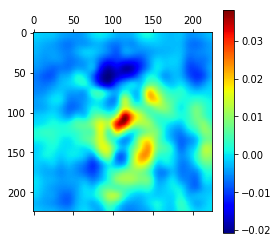

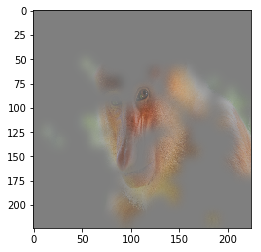

In [7]:
plot_heatmap(heatmap, blur=5)
plot_heatmap_cover(heatmap, k_image.img_to_array(image) / 255, blur=5, cutoff=0.35)

### Banana

In [8]:
image_path = 'images/banana.jpeg'

# open, parse and preprocess image
image = k_image.load_img(image_path, target_size=(224, 224))
x = k_image.img_to_array(image)
x = np.expand_dims(x, axis=0)
x = k_mobilenet_v2.preprocess_input(x)

In [9]:
heatmap = generate_heatmap(model, x, shutter=(10,10))

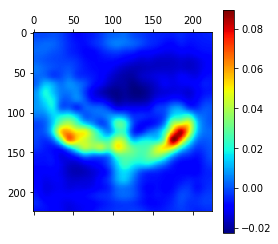

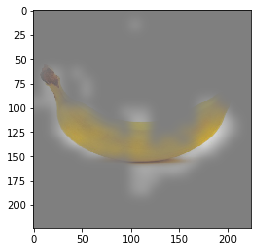

In [10]:
plot_heatmap(heatmap, blur=5)
plot_heatmap_cover(heatmap, k_image.img_to_array(image) / 255, blur=5, cutoff=0.2)